In [1]:
import torch
from torch import nn
import logging
import yaml
import os
from os.path import join
import xarray as xr

from credit.data import get_forward_data
from glob import glob
import xarray as xr
import numpy as np
import imageio
import matplotlib.pyplot as plt



In [4]:
#get approx magnitudes of perturbations
debug_folder = "/glade/work/dkimpara/CREDIT_runs/latest_skebs/debug_skebs"
all_files = sorted(glob(join(debug_folder, 'perturb*')))
all_files

['/glade/work/dkimpara/CREDIT_runs/latest_skebs/debug_skebs/perturb_0',
 '/glade/work/dkimpara/CREDIT_runs/latest_skebs/debug_skebs/perturb_1',
 '/glade/work/dkimpara/CREDIT_runs/latest_skebs/debug_skebs/perturb_2',
 '/glade/work/dkimpara/CREDIT_runs/latest_skebs/debug_skebs/perturb_3',
 '/glade/work/dkimpara/CREDIT_runs/latest_skebs/debug_skebs/perturb_4',
 '/glade/work/dkimpara/CREDIT_runs/latest_skebs/debug_skebs/perturb_5',
 '/glade/work/dkimpara/CREDIT_runs/latest_skebs/debug_skebs/perturb_6',
 '/glade/work/dkimpara/CREDIT_runs/latest_skebs/debug_skebs/perturb_7',
 '/glade/work/dkimpara/CREDIT_runs/latest_skebs/debug_skebs/perturb_8',
 '/glade/work/dkimpara/CREDIT_runs/latest_skebs/debug_skebs/perturb_9']

In [5]:
patterns = []
for file in all_files:
    perturb = torch.load(file).cpu().detach().numpy()
    patterns.append(perturb)
print(perturb.shape)
all_patterns = np.stack(patterns)

(2, 32, 1, 192, 288)


/glade/derecho/scratch/dkimpara/tmp/ipykernel_130987/3079316310.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  perturb = torch.load(file).cpu().detach().numpy()


In [6]:
all_patterns.shape

(10, 2, 32, 1, 192, 288)

0.20482312

In [93]:
timestep=21600
r = 0.01
backscatter = 1.
dE = 10e-4

In [94]:
pattern = all_patterns / (timestep * np.sqrt(r * backscatter / dE))

In [97]:
pattern_max = np.max(pattern)
print(np.max(pattern_max))

1753.7958


(array([2.4193528e+07, 8.3626550e+06, 2.0317730e+06, 5.3258700e+05,
        1.6856400e+05, 6.3863000e+04, 2.3762000e+04, 8.9840000e+03,
        2.9780000e+03, 7.4600000e+02]),
 array([4.59346268e-08, 1.27559558e-01, 2.55119085e-01, 3.82678598e-01,
        5.10238111e-01, 6.37797594e-01, 7.65357137e-01, 8.92916620e-01,
        1.02047610e+00, 1.14803565e+00, 1.27559519e+00]),
 <BarContainer object of 10 artists>)

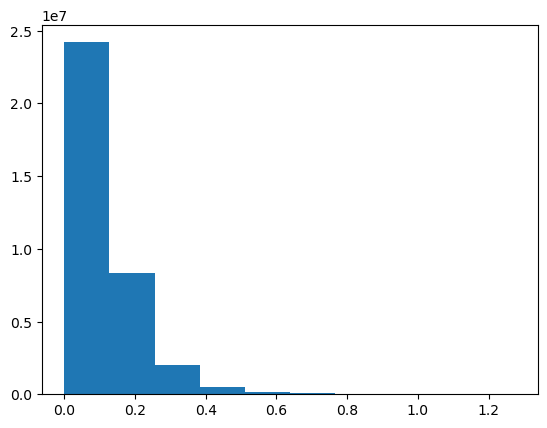

In [129]:
plt.hist(np.abs(all_patterns.flatten()))

In [99]:
#adjusting pattern
dv_max = timestep * np.sqrt(0.01 * 1.0 / dE) * pattern_max
print(dv_max)

119793366.80863811


In [3]:
# scaler files
config = "/glade/work/dkimpara/CREDIT_runs/latest_skebs/model.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

mean_path = conf["data"]["mean_path"]
std_path = conf["data"]["std_path"]

In [4]:
mean = xr.open_dataset(mean_path)
std = xr.open_dataset(std_path)

In [5]:
mean

<xarray.Dataset> Size: 1kB
Dimensions:   (ilev: 33, level: 32)
Coordinates:
  * ilev      (ilev) float32 132B 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * level     (level) float32 128B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
Data variables: (12/39)
    CLDHGH    float32 4B ...
    CLDLOW    float32 4B ...
    CLDMED    float32 4B ...
    CLDTOT    float32 4B ...
    FLDS      float32 4B ...
    FLNS      float32 4B ...
    ...        ...
    TAUY      float32 4B ...
    TREFHT    float32 4B ...
    U         (level) float32 128B ...
    U10       float32 4B ...
    V         (level) float32 128B ...
    ZMMU      (level) float32 128B ...

In [27]:
print(mean.U.min().values, mean.U.max().values)
print(mean.V.min().values, mean.V.max().values)

-0.10183653235435486 13.926475524902344
-0.06349807977676392 0.26831766963005066


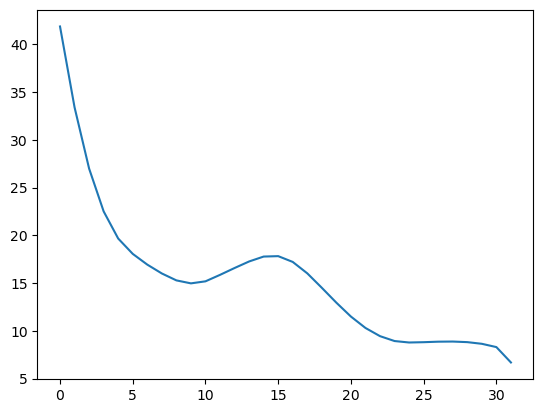

In [122]:
plt.plot(np.arange(std.U.shape[0]), std.U)

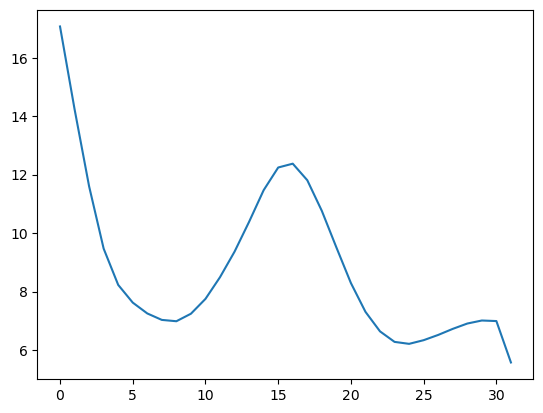

In [123]:
plt.plot(np.arange(std.U.shape[0]), std.V)

In [124]:
total_std = np.sqrt(std.U**2 + std.V**2)
c_sigma = 2 * total_std

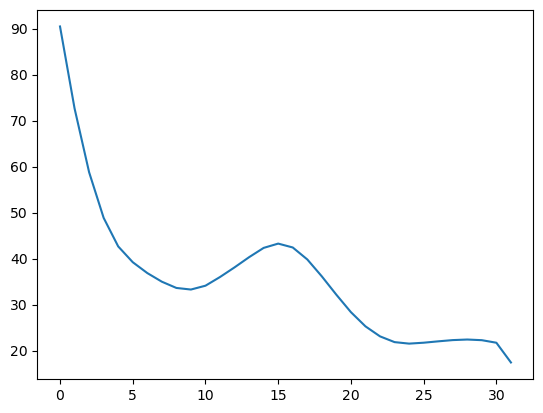

In [125]:
plt.plot(np.arange(32), c_sigma)

In [36]:
pattern_adjustment = two_sigma / dv_max * 0.01

In [37]:
dv_adjust = timestep * np.sqrt(0.01 * 1.0 / dE) * pattern_max * pattern_adjustment
print(dv_adjust)

<xarray.DataArray (level: 32)> Size: 128B
array([0.9044408 , 0.726358  , 0.58767974, 0.48846757, 0.42643854,
       0.3921535 , 0.36854675, 0.3497838 , 0.33618936, 0.3327337 ,
       0.34106702, 0.35995775, 0.38093683, 0.4030787 , 0.4232376 ,
       0.43256503, 0.4241489 , 0.39814422, 0.3613196 , 0.32140666,
       0.28355142, 0.2526945 , 0.2309666 , 0.2184555 , 0.21519175,
       0.21717204, 0.22014758, 0.222849  , 0.22409521, 0.22266065,
       0.21711133, 0.17421131], dtype=float32)
Coordinates:
  * level    (level) float32 128B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6


In [40]:
pattern_adjustment[::-1]

<xarray.DataArray (level: 32)> Size: 128B
array([1.1990416e-09, 1.4943090e-09, 1.5325031e-09, 1.5423768e-09,
       1.5337995e-09, 1.5152065e-09, 1.4947268e-09, 1.4810971e-09,
       1.5035604e-09, 1.5896704e-09, 1.7392165e-09, 1.9515953e-09,
       2.2121409e-09, 2.4868492e-09, 2.7403013e-09, 2.9192833e-09,
       2.9772089e-09, 2.9130112e-09, 2.7742639e-09, 2.6218683e-09,
       2.4774760e-09, 2.3474569e-09, 2.2901012e-09, 2.3138855e-09,
       2.4074518e-09, 2.5365914e-09, 2.6990692e-09, 2.9350422e-09,
       3.3619687e-09, 4.0448147e-09, 4.9992934e-09, 6.2249814e-09],
      dtype=float32)
Coordinates:
  * level    (level) float32 128B 992.6 976.3 957.5 936.2 ... 14.36 7.595 3.643

In [130]:
da = xr.DataArray(
    np.arange(6).reshape(2, 3), [("x", ["a", "b"]), ("y", [10, 20, 30])]
)

In [133]:
xr.concat([da.isel(y=slice(0, 1)), da.isel(y=slice(1, None))], dim="q")

<xarray.DataArray (q: 2, x: 2, y: 3)> Size: 96B
array([[[ 0., nan, nan],
        [ 3., nan, nan]],

       [[nan,  1.,  2.],
        [nan,  4.,  5.]]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 10 20 30
Dimensions without coordinates: q

In [132]:
da

<xarray.DataArray (x: 2, y: 3)> Size: 48B
array([[0, 1, 2],
       [3, 4, 5]])
Coordinates:
  * x        (x) <U1 8B 'a' 'b'
  * y        (y) int64 24B 10 20 30